In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Load Dataset
df = pd.read_csv("train.csv")

In [5]:
# Drop rows with missing target
df = df.dropna(subset=['Loan Sanction Amount (USD)'])

# Fill missing values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Loan Sanction Amount (USD)')

categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Simultaneously encode categorical variables

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Target-Guided Ordinal Encoding for Categorical Columns
for col in categorical_cols:
    ordering = df.groupby(col)["Loan Sanction Amount (USD)"].mean().sort_values().index
    ordinal_map = {key: idx for idx, key in enumerate(ordering)}
    df[col] = df[col].map(ordinal_map)

/tmp/ipython-input-5-4271659433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].median())
/tmp/ipython-input-5-4271659433.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].mode()[0])


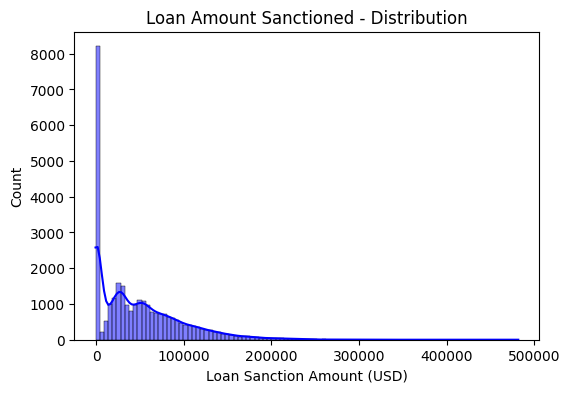

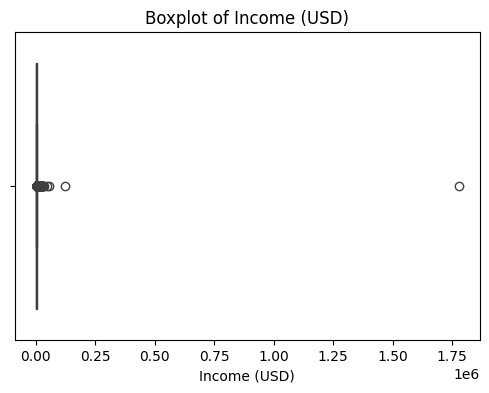

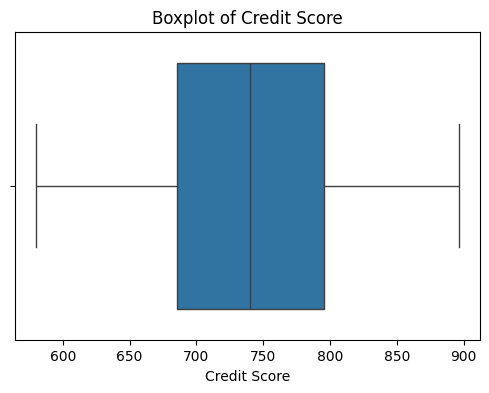

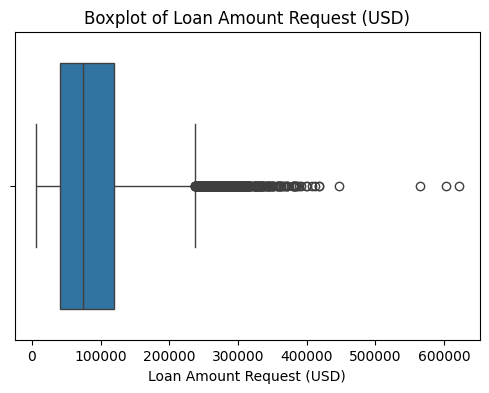

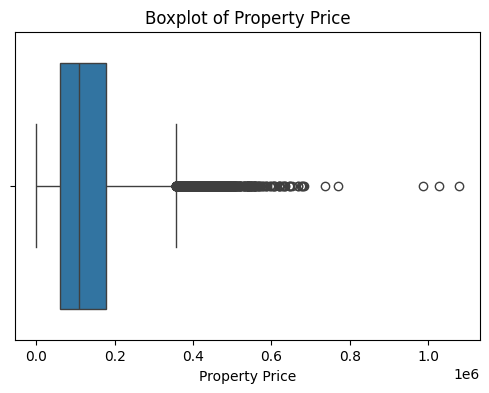

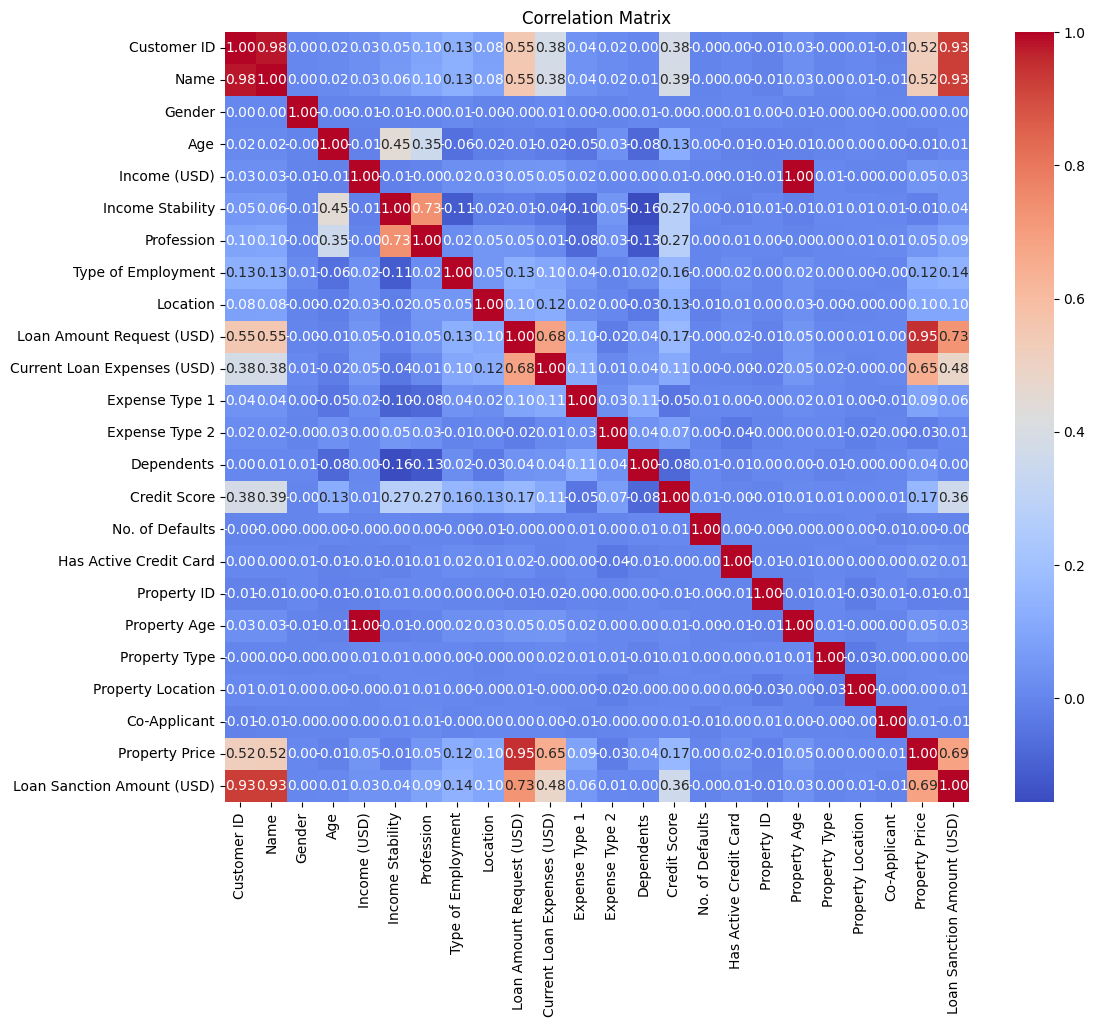

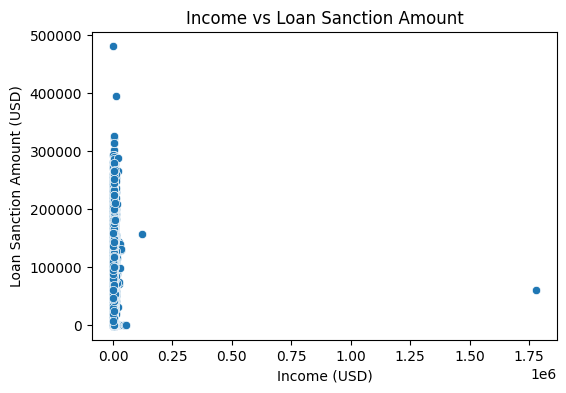

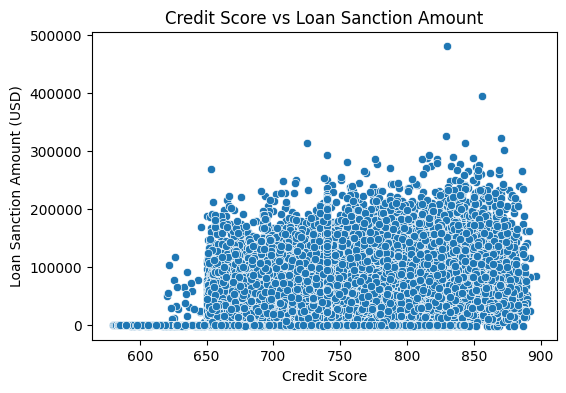

In [6]:
# EDA

# 1. Distribution of Loan Amount
plt.figure(figsize=(6, 4))
sns.histplot(df['Loan Sanction Amount (USD)'], kde=True, color='blue')
plt.title("Loan Amount Sanctioned - Distribution")
plt.show()

# 2. Boxplots for numerical features
for col in ['Income (USD)', 'Credit Score', 'Loan Amount Request (USD)', 'Property Price']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 4. Scatter plots
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Income (USD)'], y=df['Loan Sanction Amount (USD)'])
plt.title("Income vs Loan Sanction Amount")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Credit Score'], y=df['Loan Sanction Amount (USD)'])
plt.title("Credit Score vs Loan Sanction Amount")
plt.show()

In [16]:
# Feature Engineering
df['DebtToIncomeRatio'] = df['Current Loan Expenses (USD)'] / (df['Income (USD)'] + 1)
df['LoanToPropertyRatio'] = df['Loan Amount Request (USD)'] / (df['Property Price'] + 1)
df['TotalFinancialBurden'] = df['Current Loan Expenses (USD)'] + df['Loan Amount Request (USD)']
df.drop(['Customer ID', 'Name', 'Gender', 'Property ID'], axis=1, inplace=True)

df.to_csv('updated_train.csv', index=False)

# Dataset size (after prepreocessing)
print(df.shape)

(29660, 23)


In [8]:
# Define features and target
X = df.drop('Loan Sanction Amount (USD)', axis=1)
y = df['Loan Sanction Amount (USD)']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

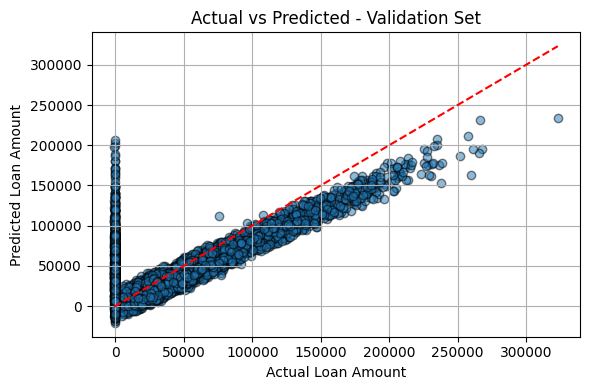

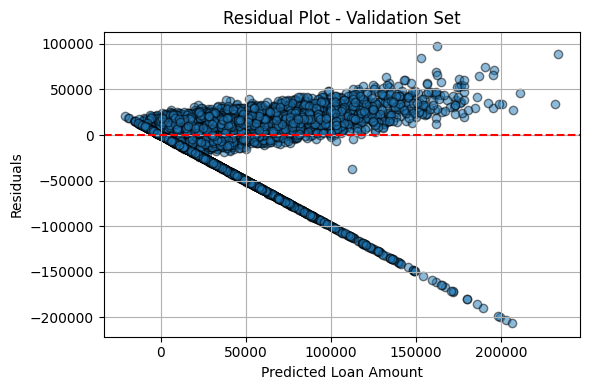

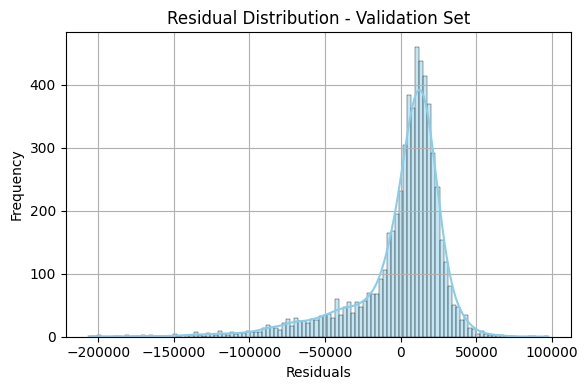

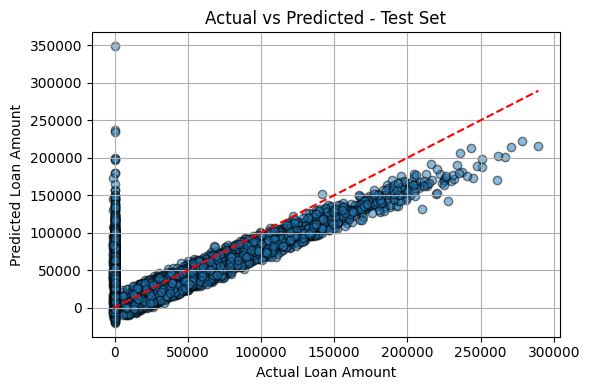

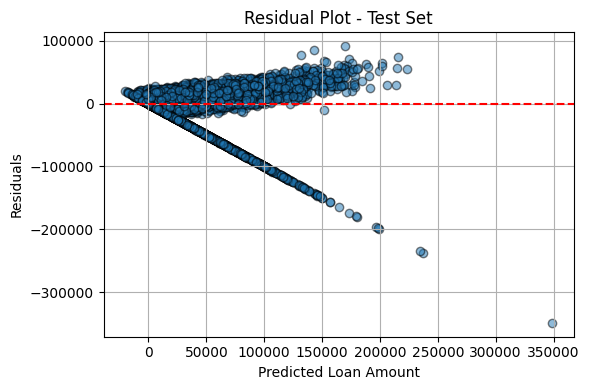

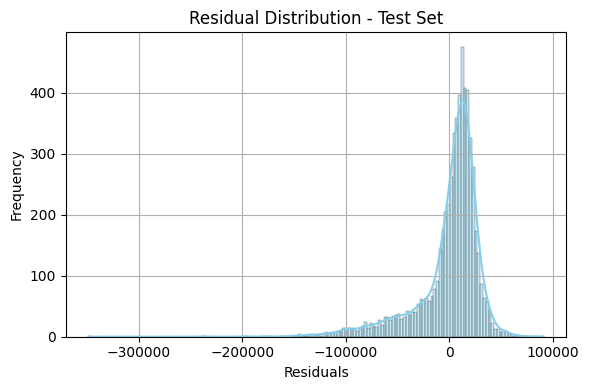

In [11]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Loan Amount")
    plt.ylabel("Predicted Loan Amount")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Loan Amount")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# For Validation Set
plot_actual_vs_predicted(y_val, y_val_pred, "Validation Set")
plot_residuals(y_val, y_val_pred, "Validation Set")
plot_residual_distribution(y_val, y_val_pred, "Validation Set")

# For Test Set
plot_actual_vs_predicted(y_test, y_test_pred, "Test Set")
plot_residuals(y_test, y_test_pred, "Test Set")
plot_residual_distribution(y_test, y_test_pred, "Test Set")

In [12]:
# Performance Metrics
mse = mean_squared_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)
print("Adjusted R2 Score:", adjusted_r2)

Mean Squared Error: 1017408194.6607875
Root Mean Squared Error: 31896.836750072685
Mean Absolute Error: 21714.30955318851
R2 Score: 0.5499689011897946
Adjusted R2 Score: 0.5482933750138216


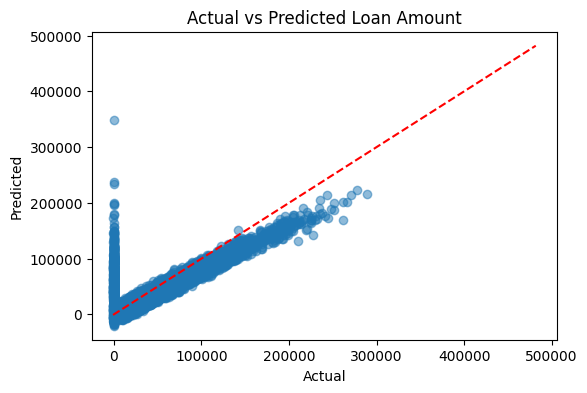

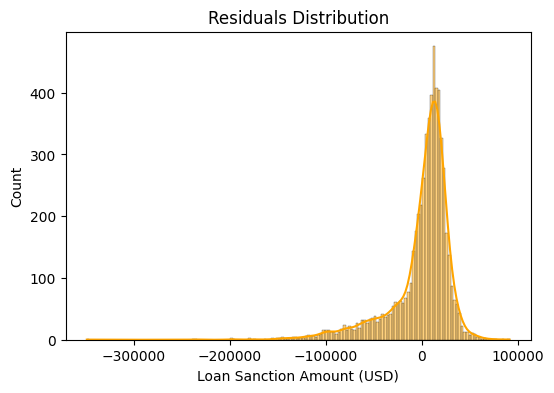

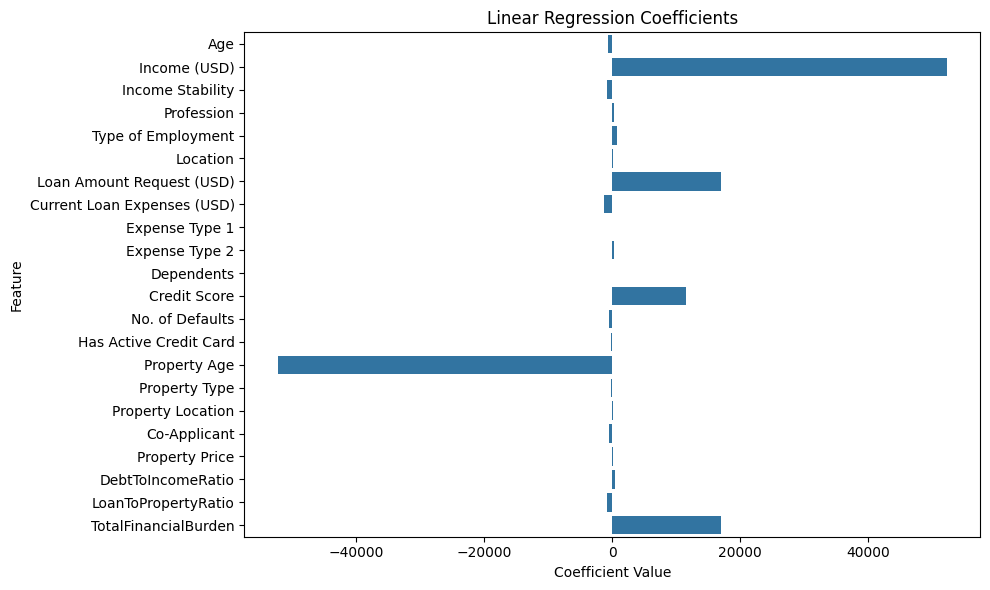

In [13]:
# Visualization of Results

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Loan Amount")
plt.show()

# Plot: Residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='orange')
plt.title("Residuals Distribution")
plt.show()

# Plot: Feature Coefficients
coefficients = model.coef_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.title("Linear Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [17]:
# Performance Metrics for Validation to compare with Test set and conclude on Overfitting or Underfitting
mse = mean_squared_error(y_val, y_val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)
print("Adjusted R2 Score:", adjusted_r2)

Mean Squared Error: 969797426.9689919
Root Mean Squared Error: 31141.570720967044
Mean Absolute Error: 21308.716483688484
R2 Score: 0.5742636441511726
Adjusted R2 Score: 0.5726785705636495
